# EECS 498-007/598-005 Final Project: Single-Image Super-Resolution

Kaiming CHENG, #68076318

##  Single-Image Super-Resolution

### Introduction

In the task of single-image super-resolution, a network receives as input a low-resolution image and it produces as output a higher-resolution version of the image. This is in general an underspecified problem – there are many possible high-resolution images that could correspond to the same low-resolution image. However, by training on datasets of corresponding high- and low-resolution images, a neural network can learn priors about the visual world that let it predict a plausible high-resolution output for any low-resolution input.

Similar to semantic segmentation, we can use a fully convolutional network to build a model for single-image super-resolution. The input to the model is a low-resolution image of shape 3 x H x W; the image goes through a series of convolution layers and upsampling layers (nearest-neighbor or bilinear upsampling, or transpose convolution) and eventually outputs a high-resolution output of shape 3 x fH x fW where f is the super-resolution factor; typically we have f=2, f=3, or f=4. During training the network output is compared with the true ground-truth output using an L2, L1, or some other loss function.


## Table of Contents

In this report I will utilize two different methods to reconstruct the super-resolution image based on the low-resolution input, named SRCNN and FSRCNN, where SR means super-resolution. FSRCNN is an accelerated version of SRCNN.

1. **Part I (Preparation)**: We will load and preprocess a General 100 dataset which consists of 100 original iamges collected from various environments.
2. **Part II (Model architecture)**: We will look how to implement building blocks of a SRCNN and FSRCNN. 

 SRCNN will consist of following blocks
   1. Patch extraction and representation
   2. Non-linear mapping
   3. Reconstruction

 FSRCNN will consist of following blocks
   1. Feature extraction
   2. Shrinking
   3. Non-linear mapping
   4. Expanding
   5. Deconvolution

The main references for SRCNN and FSRCNN:

SRCNN: Dong et al, “Image super-resolution using deep convolutional networks”, TPAMI 2015.

FSRCNN: Dong et al, “Accelerating the super-resolution convolutional neural network”, ECCV 2016.

3. **Part III (Data Loading and training)**: During training we will consider experiment with different optimizers, training losses, model architectures, and 
work with different super-resolution factors (2x, 3x, or 4x). 
4. **Part IV (Evaluation)**: In this part I will evaluate each model and report performance on the Set5 and Set14 datasets using PSNR and SSIM. Also I will 
compare against bilinear and bicubic upsampling and 
expect my model to outperfrom these baselines. 



## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment.



In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [316]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A3 folder, then '2022WI/A3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'Final Project')
print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'single_image_super_resolution.py', 'single-image super-resolution.ipynb', 'fsrcnn_tuned.pth', 'srcnn4.pth', 'srcnn3.pth', 'srcnn2.pth', 'fsrcnn2.pth', 'srcnn_light.pth']


In [317]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from single_image_super_resolution import hello
hello()

from helper import hello_helper
hello_helper()

single_image_super_resolution_path = os.path.join(GOOGLE_DRIVE_PATH, 'single_image_super_resolution.py')
single_image_super_resolution_time = time.ctime(os.path.getmtime(single_image_super_resolution_path))
print('single_image_super_resolution.py last edited on %s' % single_image_super_resolution_time)

Hello from single_image_super_resolution.py!
Hello from a3_helper.py!
single_image_super_resolution.py last edited on Mon Apr 25 22:34:04 2022


# Preparation

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
from PIL import Image
import numpy as np
import cv2
import skimage
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the General100 dataset
This is a dataset called General100 consists of 100 images. let's see some examples.




100


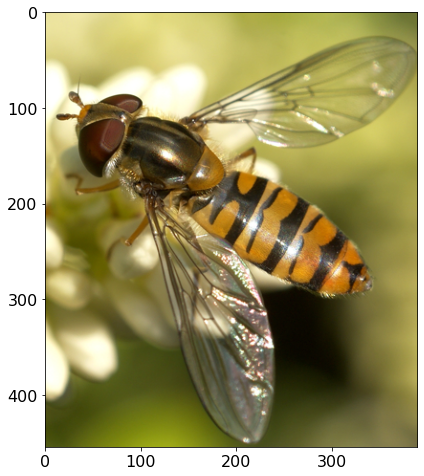

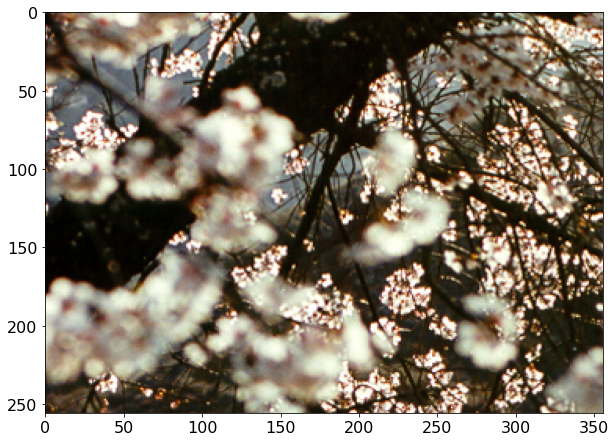

In [320]:
from single_image_super_resolution import load_training_samples
train = load_training_samples()
print(len(train))
plt.imshow(train[0])
plt.show()
plt.imshow(train[89])
plt.show()

## YCbCr
One important detail of super-resolution methods is the color channel that the model uses for training and evaluation. Instead of RGB color space, another important color space is YCbCr. In this color space, Y is a grayscale color channel (luma) and Cb and Cr are two channels giving the color of the image (chroma).

In this part I will transform the image from RGB to YCbCr color space; the neural network receives the low-resolution Y channel and predicts a high-resolution Y channel, while the Cb and Cr channels are upsampled using bicubic interpolation.

During training, the loss only compares the predicted and ground-truth Y channels, and during evaluation we compute PSNR and SSIM between the predicted and ground-truth Y channels as a convention.

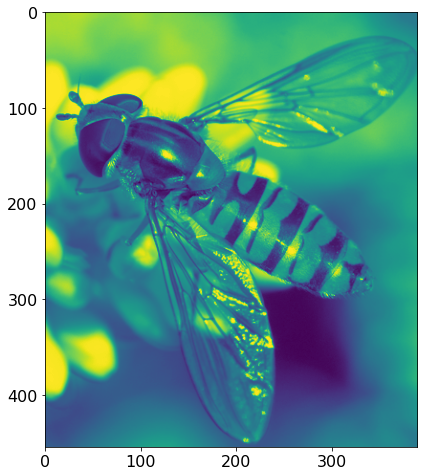

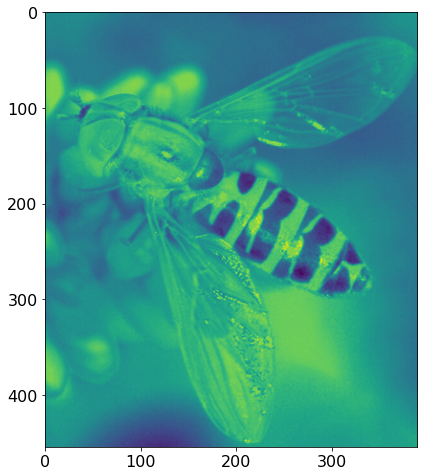

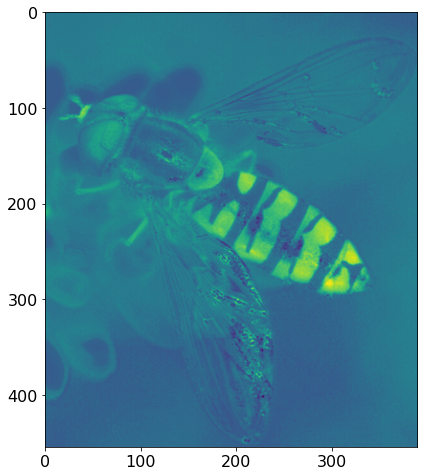

In [8]:
from skimage import color
ycbcr = skimage.color.rgb2ycbcr(train[0])
plt.imshow(ycbcr[:, :, 0])
plt.show()
plt.imshow(ycbcr[:, :, 1])
plt.show()
plt.imshow(ycbcr[:, :, 2])
plt.show()

The shape of the image.

In [9]:
train_ycbcr = {}
for i in range(len(train)):
  y = skimage.color.rgb2ycbcr(train[i])[:, :, 0]
  train_ycbcr[i] = np.expand_dims(y, 2)
print(train_ycbcr[0].shape)

(455, 390, 1)


## Input and ground-truth pairs

We now have the original images, but for training we need to first generate ground-truth sub-images by cropping them into f_sub*f_sub pixel sub images. This function sub_image is used to generate sub-images from our original training samples. The ground truth images {yi} are prepared as f_sub×f_sub×c-pixel sub-images randomly cropped from the training images. After that we also implement a bluring and down-sampling for the subimages to create a training
pairs.

In [56]:
from single_image_super_resolution import sub_image
training_pairs_y = sub_image(train_ycbcr, f_sub=34)
print(len(training_pairs_y))
print(training_pairs_y[0][0].shape)
print(training_pairs_y[0][1].shape)
training_pairs_y_3 = sub_image(train_ycbcr, f_sub=34, scale_factor=3)
print(training_pairs_y_3[0][1].shape)
training_pairs_y_4 = sub_image(train_ycbcr, f_sub=34, scale_factor=4)
print(training_pairs_y_4[0][1].shape)

94907
(34, 34, 1)
(17, 17)
(12, 12)
(9, 9)


## Image preprocessing

Bicubic_interpolation is an up-sampling method we used as the first step before training. A scale factor is also needed here to indicate the scale of up-sampling. This should be the same as our down-sampling scale factor.

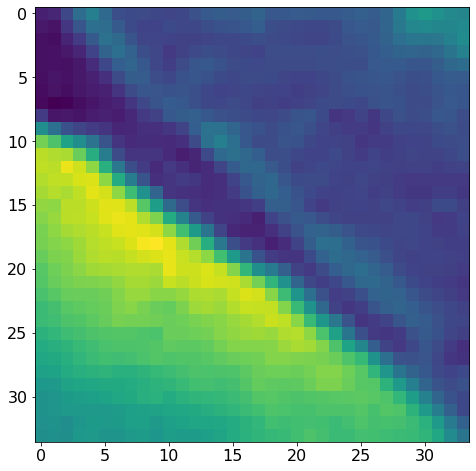

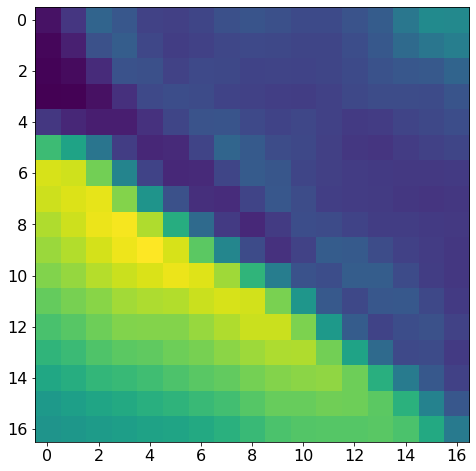

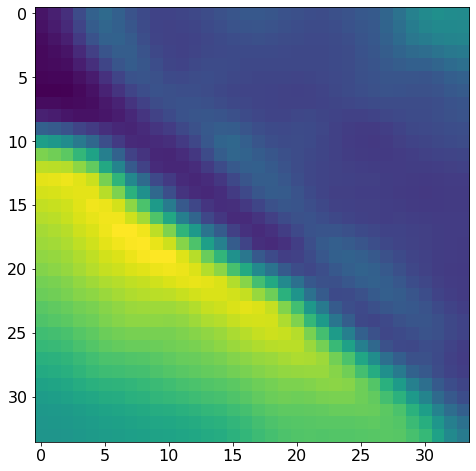

In [11]:
from single_image_super_resolution import bicubic_interpolation

bicubic_inter = bicubic_interpolation(training_pairs_y[5254][1])
plt.imshow(training_pairs_y[5254][0].squeeze(2))
plt.show()
plt.imshow(training_pairs_y[5254][1])
plt.show()
plt.imshow(bicubic_inter)
plt.show()

We can see that the the up-sampled image after down-sampling is of the same size as the ground-truth, but looks more regular.

In [57]:
train_inter_pairs = {}
for i in range(len(training_pairs_y)):
  train_inter_pairs[i] = [torch.tensor(training_pairs_y[i][0], dtype=torch.float32), 
                          torch.tensor(bicubic_interpolation(training_pairs_y[i][1]),  dtype=torch.float32)]

# Model architecture

## SRCNN


SRCNN will consist of following blocks, we set default parameter as n1=64, n2=32, f1=9, f2=1, f3=5. Each convolutional layers are followed by a Relu layer.
   1. Patch extraction and representation

   The first convolutional layer with (1, n1, kernel_size=f1)

   2. Non-linear mapping

   The second convolutional layer with (n1, n2, kernel_size=f2)

   3. Reconstruction

   The third convolutional layer with (n2, 1, kernel_size=f3), which maps the feature maps back into the reconstructed super-resolution image.


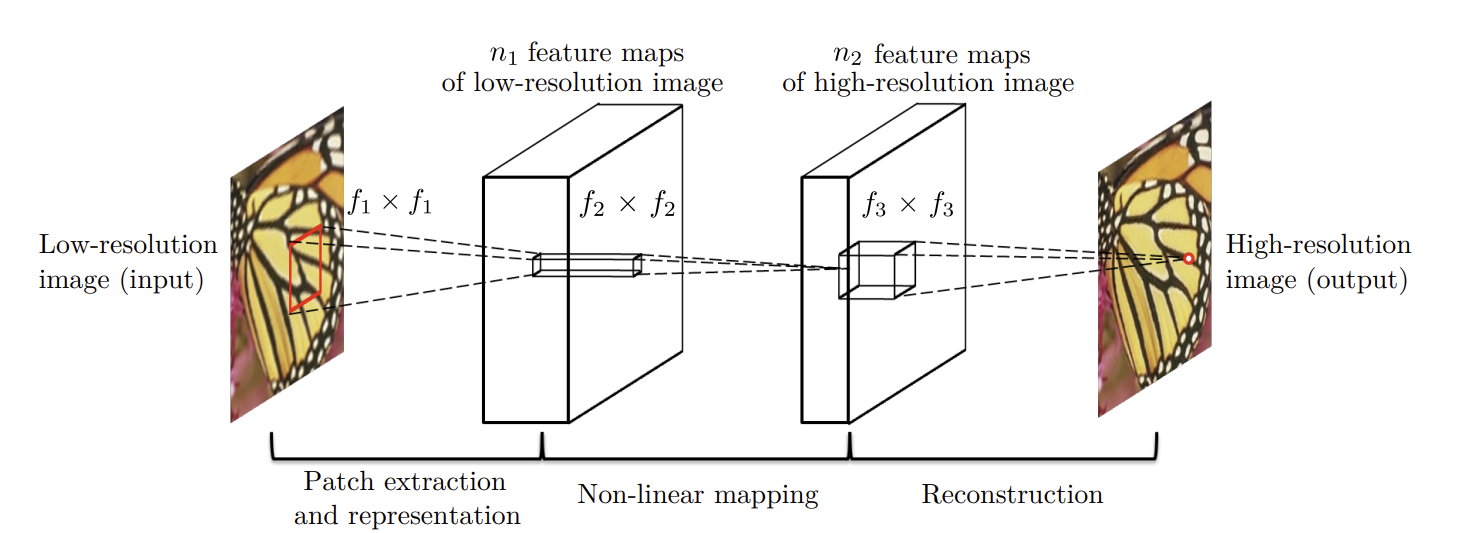

In [302]:
from single_image_super_resolution import SRCNN

srcnn = SRCNN(num_channels=1)
input = torch.tensor(train_inter_pairs[0][1], dtype=torch.float32)
input = input.permute(0, 1).unsqueeze(0).unsqueeze(0)

out = srcnn(input)
print(out.shape)
# plt.imshow(out)
# plt.show()

torch.Size([1, 1, 34, 34])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Note that our input and ouput are of the same size. However, be careful that the input here are not the original lower-resolution image(it has been bicubic interpolated). 

## FSRCNN

FSRCNN will consist of following blocks. We set default parameter as s=12, d=56, m=4. Each convolutional layers are followed by a PRelu layer.
   1. Feature extraction

   The first convolutional layer with (1, d, kernel_size=5)

   2. Shrinking

   The second convolutional layer with (d, s, kernel_size=1)

   3. Non-linear mapping

   m consecutive convolutional layer with (s, s, kernel_size=1)

   4. Expanding

   Convolutional layer with (s, d, kernel_size=1)

   5. Deconvolution

   A donvolutional layer with (d, 1, kernel_size=9, stride=scale), which maps the feature maps back into the reconstructed super-resolution image.

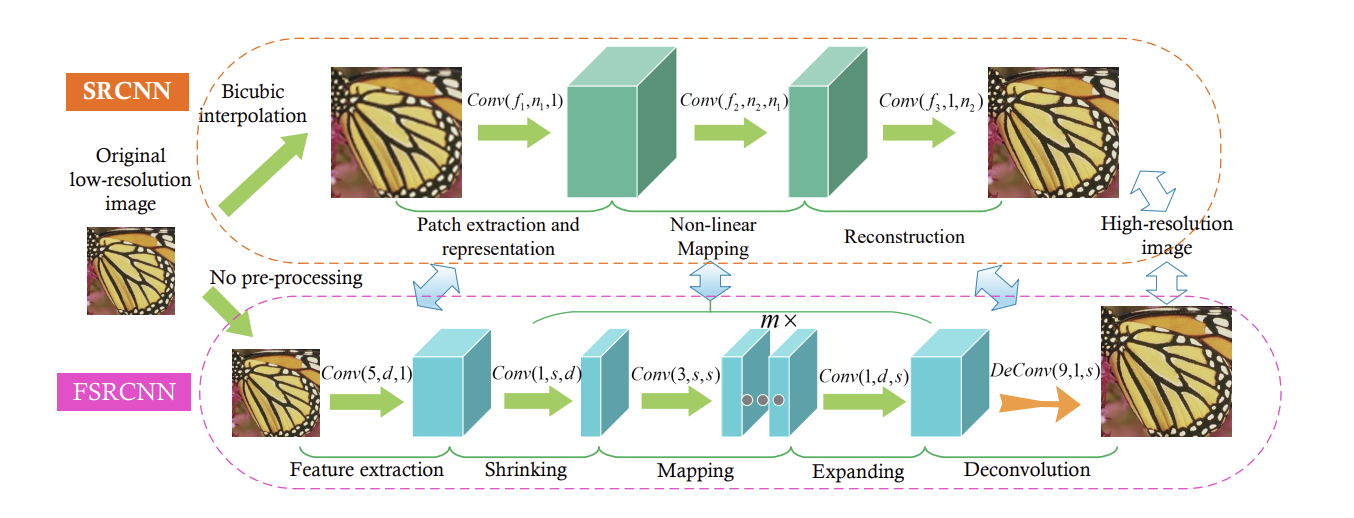

In [242]:
from single_image_super_resolution import FSRCNN

fsrcnn = FSRCNN(num_channels=1)
input = torch.tensor(train_inter_pairs[0][1], dtype=torch.float32)
input = input.unsqueeze(0).unsqueeze(0)

out = fsrcnn(input)
print(out.shape)
# plt.imshow(out)
# plt.show()

torch.Size([1, 1, 34, 34])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


The output are two times size as the input since in FSRCNN we do not implement interpolating before training, thus the input size here is 1/scale_factor of the output size.

# Training 

## Loss

We will use MSE loss and L1 loss in training.

In [ ]:
loss = torch.nn.MSELoss(reduction='mean')
gt = torch.tensor(train_inter_pairs[0][0], dtype=torch.float32)
gt = gt.view(1, 1, 34, 34)
print(loss(out, gt))

tensor(40959.4375, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


## Training validation split

Create a data_dict for training and evaluation.

In [58]:
from single_image_super_resolution import data_dict_transform
data_dict = data_dict_transform(train_inter_pairs)

In [59]:
from single_image_super_resolution import train_val_split
train_val_split(data_dict)
print(len(data_dict['X_train']))
print(len(data_dict['X_val']))

65604
16401


Start training!

Training started...
[epoch: 1] [loss:  25.6501 ] val_loss: [val_loss  2.5327 ]


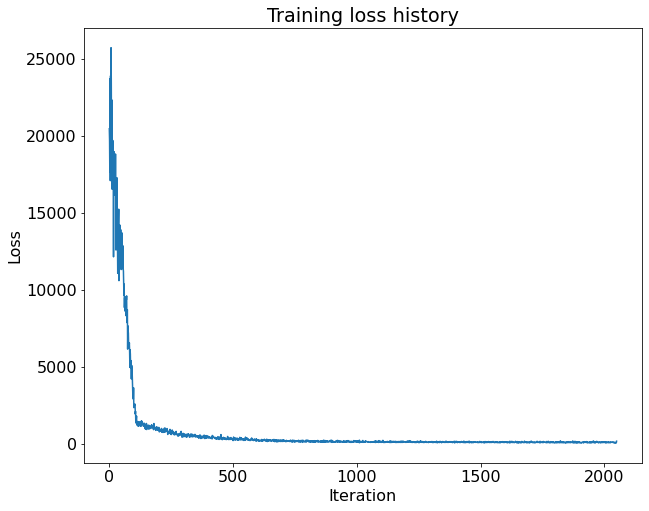

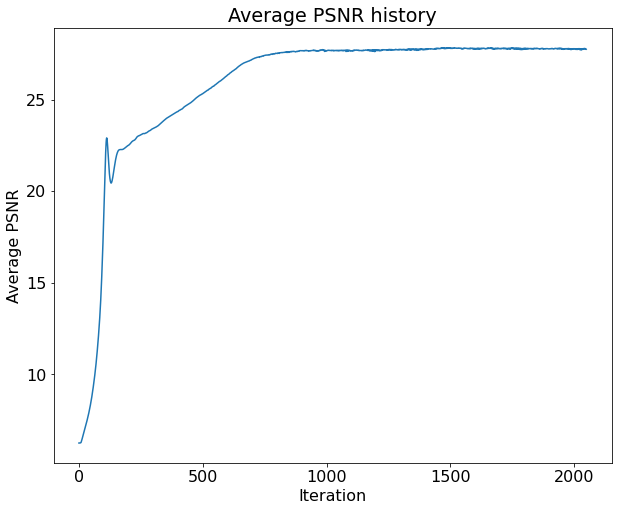

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [305]:
from single_image_super_resolution import train_srcnn
from single_image_super_resolution import load_evaluation_set

data_dict_eval = {}
data_dict_eval['lr_2'] = load_evaluation_set()
data_dict_eval['hr_2'] = load_evaluation_set(form='HR')

train_srcnn(image_data=data_dict, data_eval=data_dict_eval, path = 'srcnn2.pth')

Now let's turn to the FSRCNN. Note that this time we do not need bicubic interpolation for y channel.

In [215]:
from single_image_super_resolution import sub_image
training_pairs_y = sub_image(train_ycbcr, f_sub=34)
print(len(training_pairs_y))
print(training_pairs_y[0][0].shape)
print(training_pairs_y[0][1].shape)

94907
(34, 34, 1)
(17, 17)


In [241]:
train_pairs_fsrcnn = {}
for i in range(len(training_pairs_y)):
  train_pairs_fsrcnn[i] = [torch.tensor(training_pairs_y[i][0], dtype=torch.float32), 
                          torch.tensor(training_pairs_y[i][1],  dtype=torch.float32)]

In [243]:
from single_image_super_resolution import data_dict_transform_fsrcnn
data_dict_fsrcnn = data_dict_transform_fsrcnn(train_pairs_fsrcnn, fsub=34)
train_val_split(data_dict_fsrcnn)

Training started...
[epoch: 1] [loss:  52.8405 ] val_loss: [val_loss  6.8250 ]


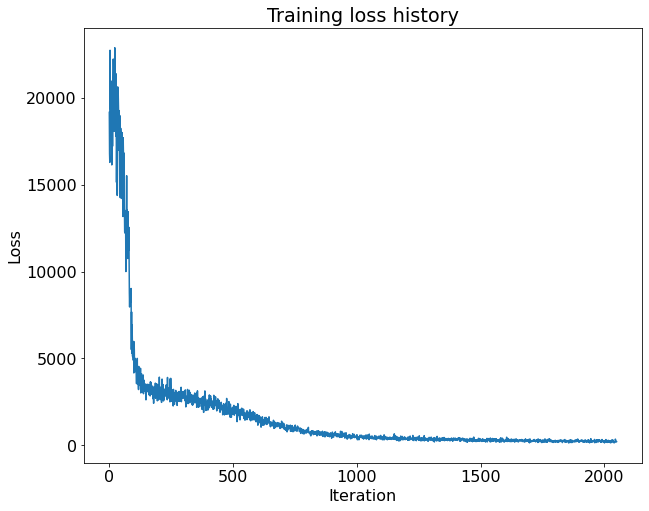

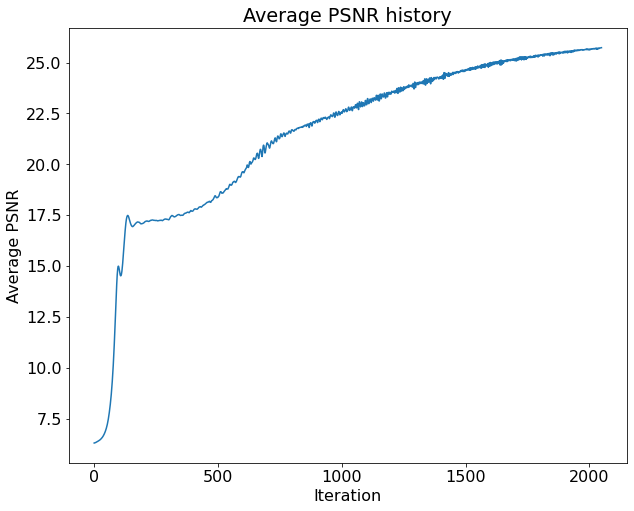

FSRCNN(
  (conv1): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
  (conv5): ConvTranspose2d(56, 1, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (prelu): PReLU(num_parameters=1)
)

In [306]:
train_srcnn(image_data=data_dict_fsrcnn, data_eval=data_dict_eval, method = 'fsrcnn', path='fsrcnn2.pth')

From the training plots and loss history I find that for both SRCNN and FSRCNN the loss drops and the PSNR climbs quickly within 50 iterations. After that both of PSNR and loss change steadily and are about to converge after 2000 iterations. The two methods have the same super-resolution effect with a converged average PSNR about 28, while the FSRCNN is much faster to train than SRCNN.

## Different super-resolution factors 

### Scale factor 3 & 4

Until now we have trained the model with a down-sampling scale factor of 2. In this section we will train our model with scale factor of 3 and 4. Note that the training data set resolution are adjusted correspondingly.

In [278]:
from single_image_super_resolution import sub_image
training_pairs_y = sub_image(train_ycbcr, f_sub=36)
print(len(training_pairs_y))
print(training_pairs_y[0][0].shape)
print(training_pairs_y[0][1].shape)
training_pairs_y_3 = sub_image(train_ycbcr, f_sub=36, scale_factor=3)
print(training_pairs_y_3[0][1].shape)
training_pairs_y_4 = sub_image(train_ycbcr, f_sub=36, scale_factor=4)
print(training_pairs_y_4[0][1].shape)

94907
(36, 36, 1)
(18, 18)
(12, 12)
(9, 9)


In [289]:
train_pairs_3 = {}
for i in range(len(training_pairs_y_3)):
  train_pairs_3[i] = [torch.tensor(training_pairs_y_3[i][0], dtype=torch.float32), 
                          torch.tensor(bicubic_interpolation(training_pairs_y_3[i][1],3),  dtype=torch.float32)]

In [290]:
data_dict_3 = data_dict_transform(train_pairs_3, fsub=36)
train_val_split(data_dict_3)

Training started...
[epoch: 1] [loss:  24.5040 ] val_loss: [val_loss  3.4964 ]


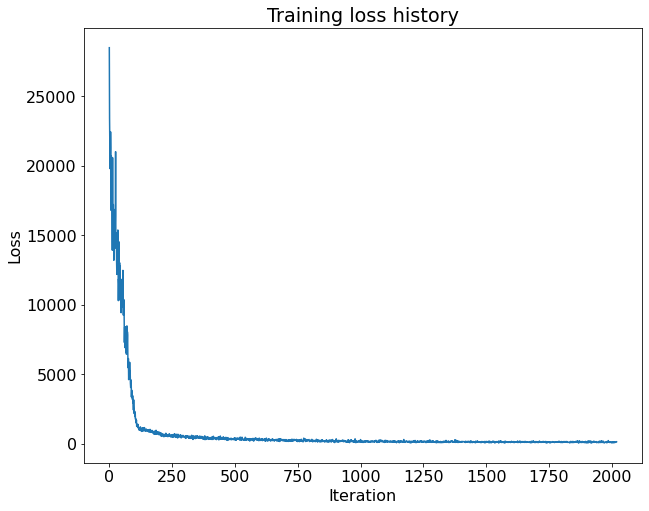

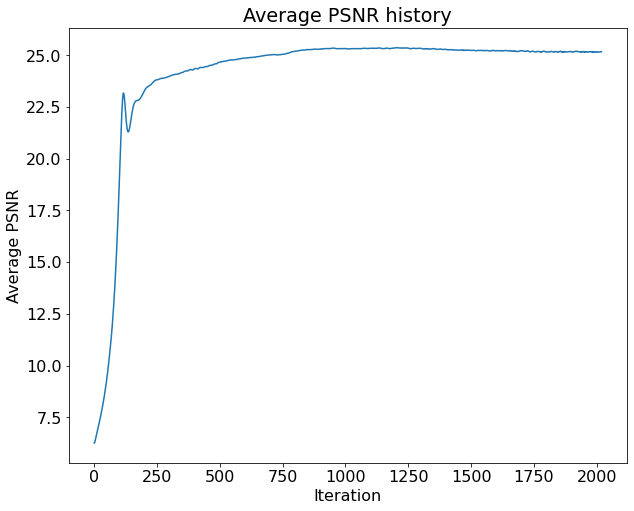

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [304]:
train_srcnn(image_data=data_dict_3, data_eval=data_dict_eval, scale=3)

In [294]:
train_pairs_4 = {}
for i in range(len(training_pairs_y_4)):
  train_pairs_4[i] = [torch.tensor(training_pairs_y_4[i][0], dtype=torch.float32), 
                          torch.tensor(bicubic_interpolation(training_pairs_y_4[i][1],4),  dtype=torch.float32)]

In [295]:
data_dict_4 = data_dict_transform(train_pairs_4, fsub=36)
train_val_split(data_dict_4)

Training started...
[epoch: 1] [loss:  17.6870 ] val_loss: [val_loss  5.3948 ]


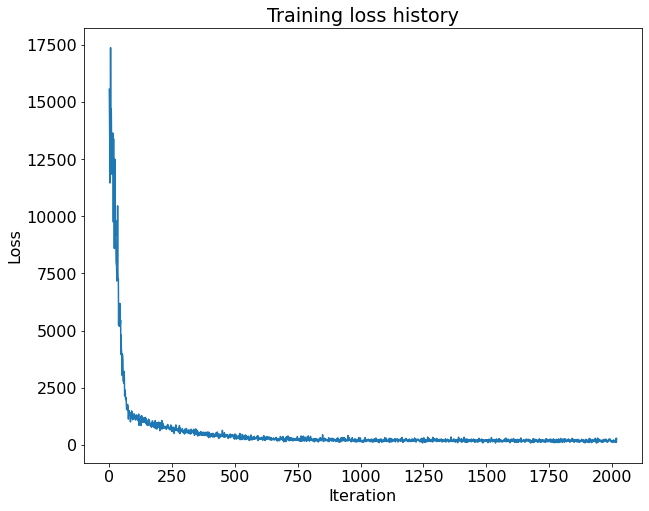

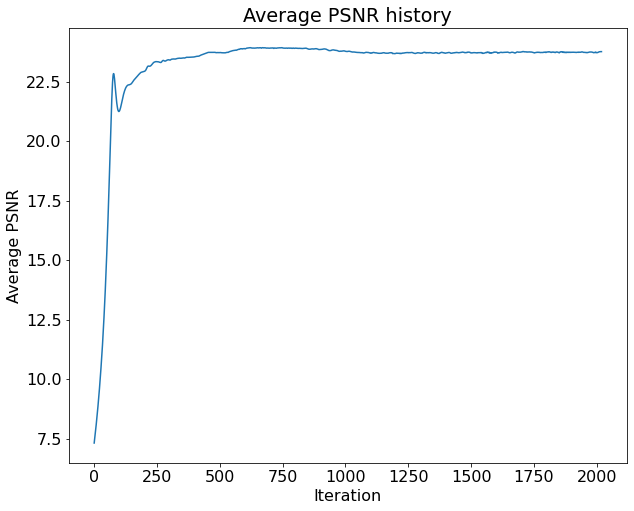

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [296]:
train_srcnn(image_data=data_dict_4, data_eval=data_dict_eval, scale=4)

Not surprisingly, the average PSNR is lower if the scale factor is larger, which means it is typically more challenging to reconstruct a super-resolution image if the input has too less information. The average PSNR are about 25 and 23.5 for scale factor 3 and 4 when using SRCNN.

## Different hyper-parameters

This time we try L1 loss instead of MSE loss, and train with a larger learning rate.

Training started...
[epoch: 1] [loss:  0.4914 ] val_loss: [val_loss  0.2427 ]
[epoch: 2] [loss:  0.2186 ] val_loss: [val_loss  0.1959 ]


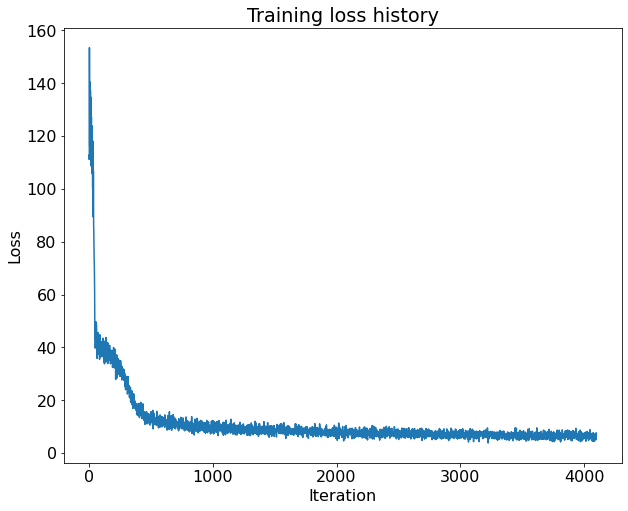

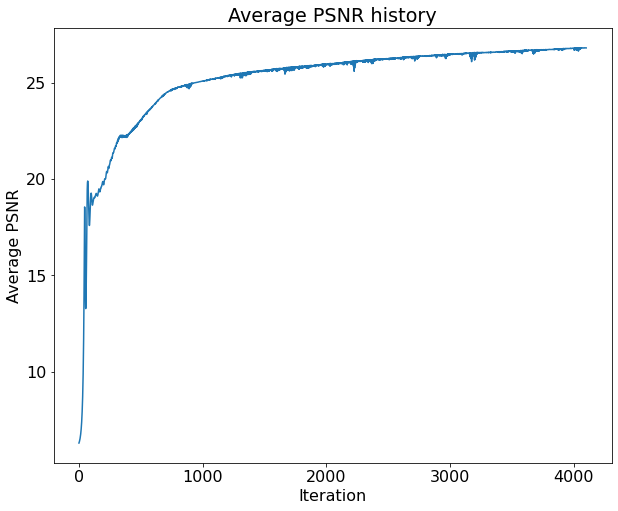

FSRCNN(
  (conv1): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
  (conv5): ConvTranspose2d(56, 1, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (prelu): PReLU(num_parameters=1)
)

In [280]:
from single_image_super_resolution import train_srcnn
# from single_image_super_resolution import load_evaluation_set

# data_dict_eval = {}
# data_dict_eval['lr_2'] = load_evaluation_set()
# data_dict_eval['hr_2'] = load_evaluation_set(form='HR')

train_srcnn(image_data=data_dict_fsrcnn, data_eval=data_dict_eval, num_epochs=2, model=FSRCNN(),
    batch_size=32,
    learning_rate=1e-4,
    method = 'fsrcnn',
    criterion = torch.nn.L1Loss(),
    path = 'fsrcnn_tuned')

## Different network architecture

Let's try some different architecture for SRCNN. For example, we can change the channel number n1 from 64 to 32, n2 from 32 to 16, which leads to a light model.

Training started...
[epoch: 1] [loss:  39.5994 ] val_loss: [val_loss  3.3718 ]


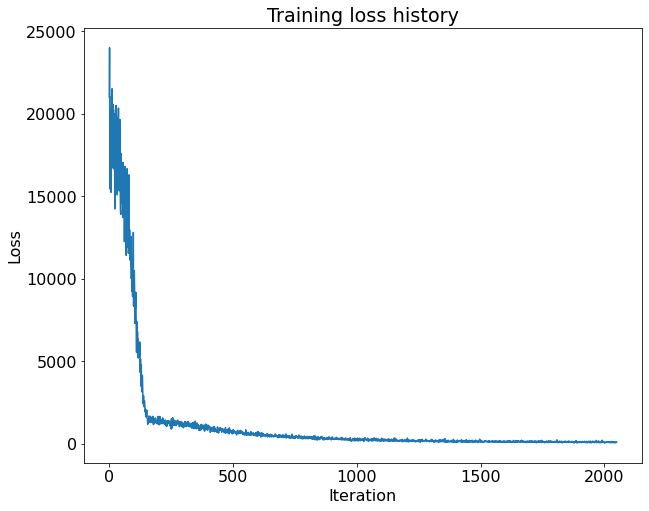

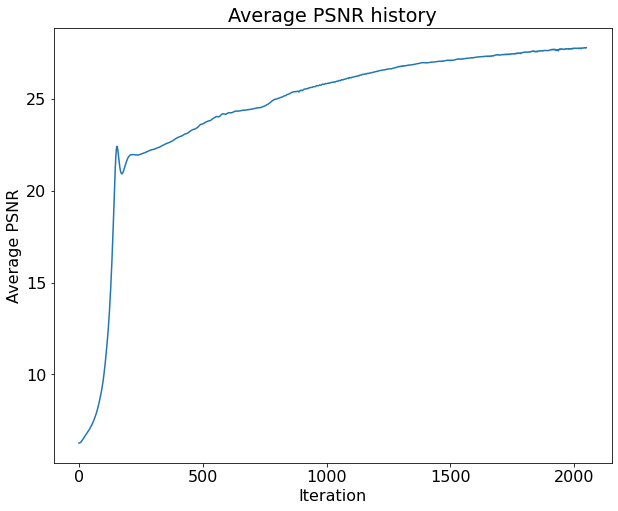

SRCNN(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [307]:
model = SRCNN(n1=32, n2=16)
train_srcnn(image_data=data_dict, model = model, data_eval=data_dict_eval, path='srcnn_light.pth')

Based on the above tuning I find that the super-resolution task is not sensitive to the deep architecture or number of model parameters. The more complex architecture does not lead to apparently higher PSNR. Also the MSE loss and L1 loss have the same effect in general and the change of learning rate contribute little to the converge of the training speed.



# Evaluation

In this part I will evaluate each model and report performance on the Set5 and Set14 datasets using PSNR and SSIM. Also I will compare against bilinear and bicubic upsampling and expect my model to outperfrom these baselines.

## Evaluation metric



### PSNR & SSIM

The term peak signal-to-noise ratio (PSNR) is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation.

The structural similarity index measure (SSIM) is a method for predicting the perceived quality of digital television and cinematic pictures, as well as other kinds of digital images and videos. SSIM is used for measuring the similarity between two images.

## Evaluation on Set5 and Set14

Below are the function for evaluation dataset loading.

In [303]:
from single_image_super_resolution import load_evaluation_set
data_dict_eval = {}
data_dict_eval['lr_2'] = load_evaluation_set()
data_dict_eval['hr_2'] = load_evaluation_set(form='HR')

data_dict_eval['lr_3'] = load_evaluation_set(scale=3, form='LR')
data_dict_eval['hr_3'] = load_evaluation_set(scale=3, form='HR')
data_dict_eval['lr_4'] = load_evaluation_set(scale=4, form='LR')
data_dict_eval['hr_4'] = load_evaluation_set(scale=4, form='HR')

Although we have seen the average PSNR on the evaluation set (Set5 and Set14, 19 images in total) during training process, it still benefits to see how the model transform the lower-resolution images into super-resolution ones.

Below I prepare some examples for the original super-resolution image, lower-resolution input, bilinear interpolation result, bicubic interpolation result and the model output. First let's see the SRCNN and FSRCNN for the 001 image in Set5.

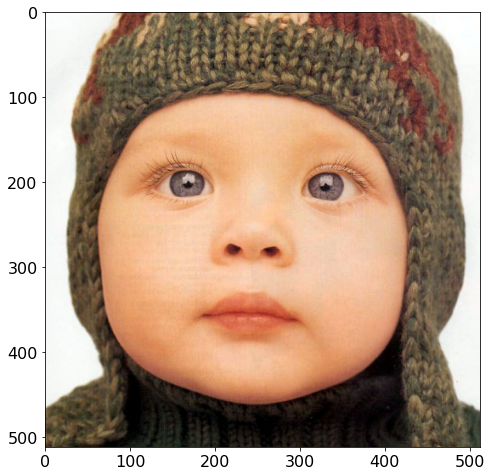

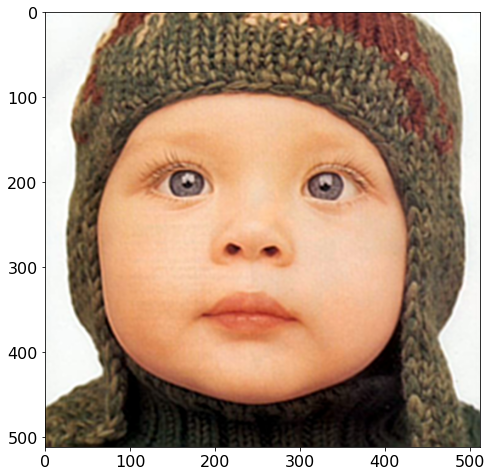

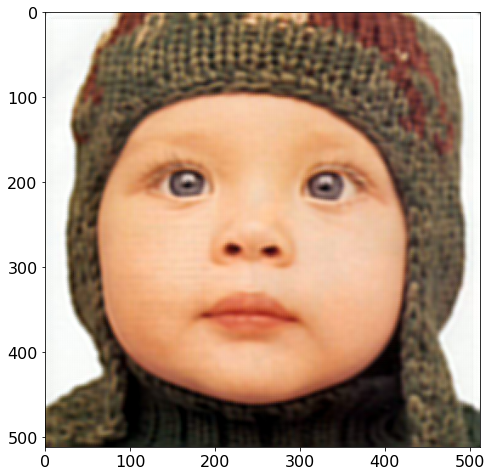

32.46301182447294
30.24107574684819


In [311]:
from single_image_super_resolution import evaluate, evaluate_metric
model1 = torch.load('/content/drive/My Drive/Final Project/srcnn2.pth')
model1.eval()
model2 = torch.load('/content/drive/My Drive/Final Project/fsrcnn2.pth')
model2.eval()
gt = Image.open('/content/drive/My Drive/Set5_SR/Set5/image_SRF_2/img_001_SRF_2_HR.png')
pic = Image.open('/content/drive/My Drive/Set5_SR/Set5/image_SRF_2/img_001_SRF_2_LR.png')
out1 = evaluate(pic, model1, method='srcnn')
out2 = evaluate(pic, model2, method='fsrcnn')
img1 = np.array(gt)
img = np.array(pic)
plt.imshow(img1)
plt.show()
plt.imshow(out1)
plt.show()
plt.imshow(out2)
plt.show()
print(skimage.metrics.peak_signal_noise_ratio(y(img1), y(out1)))
print(skimage.metrics.peak_signal_noise_ratio(y(img1), y(out2)))

It seems to me that the original one is the most natural(definitely!). The second one is the output of SRCNN and the third one is the output of FSRCNN, both of which have some difference when compared with the ground-truth. The SRCNN output is sharper and has some bordering effect. The third one generated by the FSRCNN is a little blurry and lacks even more details. But to be optimistic, the output might look decent if the image is small, or to someone who is near-sighted.

Let's see more examples with different scale factor!

### Scale factor 2

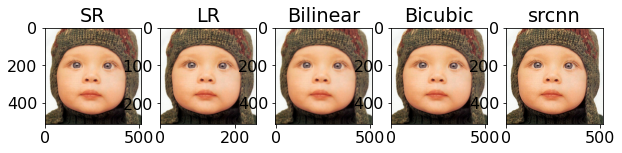

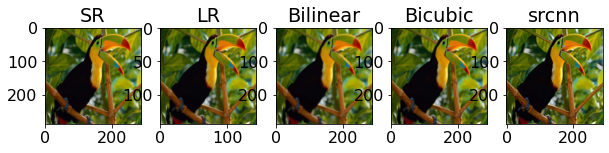

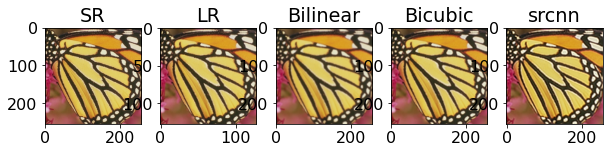

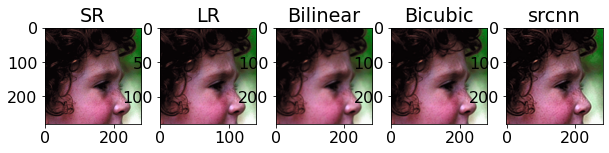

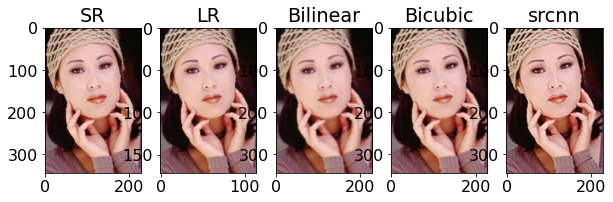

Average PSNR for Bilinear interpolation: 27.055111
Average PSNR for Bicubic interpolation: 28.473548
Average PSNR for SRCNN: 24.656350
Average SSIM for Bilinear interpolation: 0.955513
Average SSIM for Bicubic interpolation: 0.965036
Average SSIM for SRCNN: 0.933717


In [312]:
from single_image_super_resolution import evaluate, evaluate_metric, bilinear_interpolation, y, plot_set, average_psnr
score = np.ones(6)
for k in range(5):
  temp = plot_set(k+1, path='/content/drive/My Drive/Final Project/srcnn2.pth')
  for j in range(6):
    score[j] += temp[j]
score /= 6
print('Average PSNR for Bilinear interpolation: %f' % score[0])
print('Average PSNR for Bicubic interpolation: %f' % score[1])
print('Average PSNR for SRCNN: %f' % score[2])
print('Average SSIM for Bilinear interpolation: %f' % score[3])
print('Average SSIM for Bicubic interpolation: %f' % score[4])
print('Average SSIM for SRCNN: %f' % score[5])

### Scale factor 3

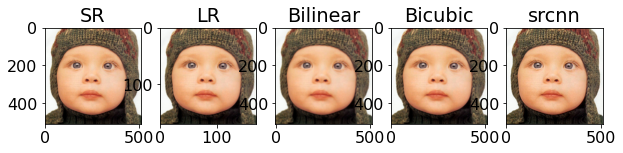

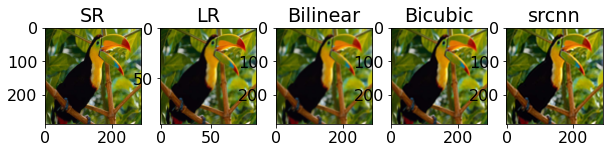

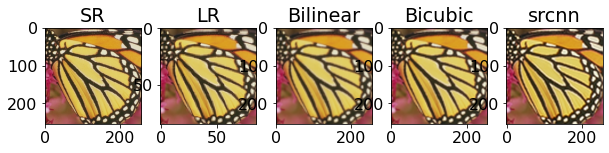

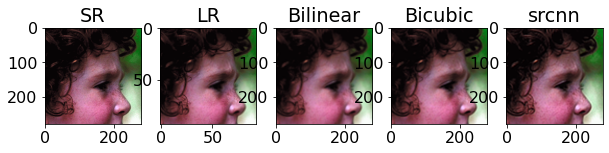

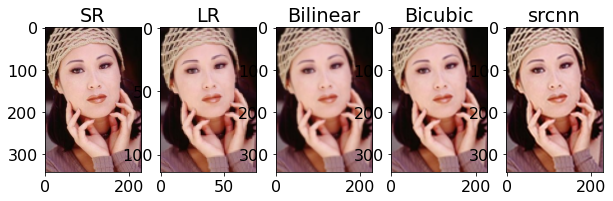

Average PSNR for Bilinear interpolation: 24.795295
Average PSNR for Bicubic interpolation: 25.689232
Average PSNR for SRCNN: 22.208243
Average SSIM for Bilinear interpolation: 0.927646
Average SSIM for Bicubic interpolation: 0.935892
Average SSIM for SRCNN: 0.899659


In [314]:
score = np.ones(6)
for k in range(5):
  temp = plot_set(k+1, path='/content/drive/My Drive/Final Project/srcnn3.pth', scale=3)
  for j in range(6):
    score[j] += temp[j]
score /= 6
print('Average PSNR for Bilinear interpolation: %f' % score[0])
print('Average PSNR for Bicubic interpolation: %f' % score[1])
print('Average PSNR for SRCNN: %f' % score[2])
print('Average SSIM for Bilinear interpolation: %f' % score[3])
print('Average SSIM for Bicubic interpolation: %f' % score[4])
print('Average SSIM for SRCNN: %f' % score[5])

### Scale factor 4

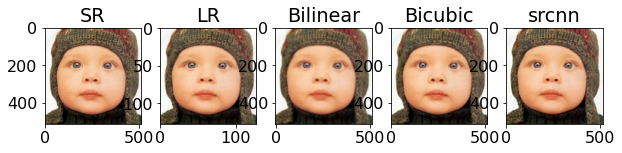

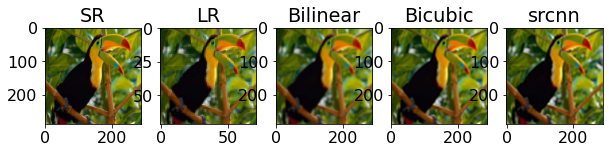

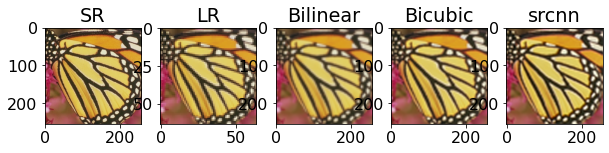

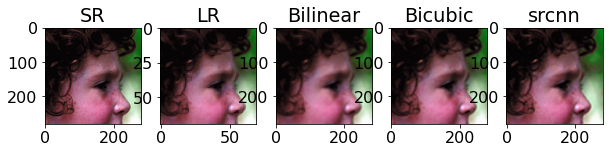

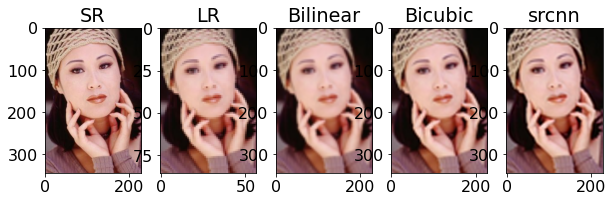

Average PSNR for Bilinear interpolation: 23.150421
Average PSNR for Bicubic interpolation: 24.025018
Average PSNR for SRCNN: 20.817209
Average SSIM for Bilinear interpolation: 0.900895
Average SSIM for Bicubic interpolation: 0.910220
Average SSIM for SRCNN: 0.872211


In [315]:
score = np.ones(6)
for k in range(5):
  temp = plot_set(k+1, path='/content/drive/My Drive/Final Project/srcnn4.pth', scale=4)
  for j in range(6):
    score[j] += temp[j]
score /= 6
print('Average PSNR for Bilinear interpolation: %f' % score[0])
print('Average PSNR for Bicubic interpolation: %f' % score[1])
print('Average PSNR for SRCNN: %f' % score[2])
print('Average SSIM for Bilinear interpolation: %f' % score[3])
print('Average SSIM for Bicubic interpolation: %f' % score[4])
print('Average SSIM for SRCNN: %f' % score[5])

From these examples we may find it hard to tell any difference between the multiple super-resolution outputs with human eyes. Actually it is even hard to distinguish the super-resolution and the low-resolution one if you do not look at them carefully. But the PSNR and SSIM metric indeed indicate that the SRCNN and FSRCNN model performs even worse than the single interpolation baseline.

In this case, the performance of the super-resolution methods are like bicubic interpolation > bilinear interpolation > SRCNN, which is out of my expectation. There are several reasons that can cause this, such as the wrong way of training sample generating or incorrect design of model. I suspect this might because I dropped all sample pairs on the border when cropping and added paddings in the SRCNN and FSRCNN convolutional layers. This is to avoid the inconvvenience brought by measuring the potential smaller size of outputs with the centeral pixels of the ground-truth. 

# Conclusion

Overall, I walked through a whole pipeline for implementing the models SRCNN and FSRCNN for single-image super-resolution. I used General100 dataset, tried three different super-resolution factors (2x, 3x, or 4x) and for each model the performance is evaluated on the Set5 and Set14 datasets using PSNR and SSIM. Also I compare the model outputs against bilinear and bicubic upsampling results. However, the metric turns out that our model does not beat the baselines.

In a nutshell, the project greatly enhanced my skills in coding from scratch on a fairly challenging computer vision task. Although the whole pipeline works well and I have printed out all the outputs successfully, the performace of the model is far below my expectation, which cannot outperform the bicubic interpolation in PSNR and SSIM. If I have more time, I will try to figure out the reason why the model does not seem to work well in this case. Anyway this is a long report, and thank you for reading!

